## testing methods for plotting ice core properties

**Adam Steer**

this notebook explores some plotting techniques aiming to visualise ice core properties, visually showing that measurements are for chunks of ice rather than point samples in the core


In [21]:
import numpy as np
from matplotlib import pyplot as plt

import matplotlib.ticker as plticker
from matplotlib.ticker import MultipleLocator



from scipy.interpolate import Akima1DInterpolator, PchipInterpolator, CubicSpline
from scipy.stats import describe

%matplotlib inline

In [3]:
# implementing Morgan William's plotting function: https://gist.github.com/morganjwilliams/fbdcef72e8d11b46b6e0a817a9c5afcc

def plot_rounded_intervals(
    intervals,
    values,
    ax=None,
    orientation="horizontal",
    color="k",
    rounding=0.1,
    baseline=0,
    **kwargs
):
    """
    Plot a step profile plot with rounded corners.
    Parameters
    ----------
    intervals : numpy.ndarray
        Array of interval/bin edges.
    values : numpy.ndarray
        Values of properties for the intervals/bins.
    ax : matplotlib.axes.Axes
        Axis to plot on, if not creating a new one.
    orientation : str
        Which orientation in which to make the plot.
    color : str 
        Color for the line plot.
    rounding : float | tuple
        Amount of rounding to apply to the profile corners. Where a tuple is provided, it 
        corresponds to the scale along the interval axis, and the scale along the value axis.
    baseline : float
        The 'zero point' of the profile, which it will return to on either end.
    Returns
    -------
    matplotlib.axes.Axes
    """
    if ax is None:
        fig, ax = plt.subplots(1)
        ax.invert_yaxis()

    if rounding is None:
        rounding = 0
    if not isinstance(rounding, tuple):
        rounding = (rounding, rounding)

    # generate interval midway points and plot markers. Set Zorder high to plot on top of lines coming net
    pts = (intervals[1:] + intervals[:-1]) / 2
    if orientation == "horizontal":
        ax.scatter(values, pts, marker="o", c="w", edgecolor=color, zorder=10 )
    else:
        ax.scatter(pts, values, marker="o", c= "w", edgecolor=color, zorder=10 )
        
    # to some extent, this might be useful - but gives non-rounded edges
    if np.isclose(rounding[0], 0):
        ax.stairs(
            values, edges=intervals, orientation=orientation, color=color, **kwargs
        )
    else:
        # bevel the corners off the step profile
        #make an array which repeats the intervals 4 times each
        ir = np.repeat(intervals, 4).astype(float)
        
        #print("intervals: {}".format(ir))
        
        #make another array starting and ending at [0,0], with repeated *values*
        vr = np.hstack(
            [[baseline, baseline], np.repeat(values, 4), [baseline, baseline]]
        ).astype(float)
        
        #print("values: {}".format(vr))
        
        # get the difference in sign between each value pair - is each step
        # a value increase or decrease?
        sign = np.sign(np.diff(np.hstack([[baseline], values, [baseline]])))
        
        #print(sign)
        
        # corner rounding - generate some points along which to interpolate a plotting line
        # the next section sets Y values for the eventual curve
        # start at element 2 - beginning of real values, put an intermediate step in one direction (+ or -)
        # maximum 1/4 of the step height up/down
        vr[2::4] -= sign * np.min(
            np.abs(
                np.vstack(
                    [
                        np.ones(intervals.size) * rounding[1],
                        np.hstack(
                            [
                                [sign[0] * rounding[1]],
                                np.diff(values) / 4,
                                [sign[-1] * rounding[1]],
                            ]
                        ),
                    ]
                )
            ),
            axis=0,
        )
        
        #at element 5, put an intermeduate step on the other direction
        vr[5::4] += sign[1:] * np.min(
            np.abs(
                np.vstack(
                    [
                        np.ones(intervals.size - 1) * rounding[1],
                        np.hstack(
                            [
                                [sign[1] * rounding[1]],
                                np.diff(values)[1:] / 4,
                                [sign[-1] * rounding[1]],
                            ]
                        ),
                    ]
                )
            ),
            axis=0,
        )
        
        #print("values 2: {}".format(vr))
        
        # here we set X values for intermediate points
        # maximum 1/4 of the bin width
        interval_offsets = np.min(
            np.vstack(
                [np.ones(intervals.size - 1) * rounding[0], np.diff(intervals) / 4]
            ),
            axis=0,
        )
        
        #print(interval_offsets)
        
        ir[3:-1:4] += interval_offsets
        ir[4::4] -= interval_offsets  # maximum half of the bin width
        
        #print(ir[4::4])
        
        # interpolation - construct a line to plot along the points made above
        _xs = np.linspace(0, ir.size, int(10 * (ir.size / rounding[0])))
        
        #print(_xs)
        
        i_interp = PchipInterpolator(np.arange(ir.size), ir)
        v_interp = PchipInterpolator(np.arange(ir.size), vr)
        #i_interp = Akima1DInterpolator(np.arange(ir.size), ir)
        #v_interp = Akima1DInterpolator(np.arange(ir.size), vr)
        #i_interp = CubicSpline(np.arange(ir.size), ir)
        #v_interp = CubicSpline(np.arange(ir.size), vr)
        # plotting

        if orientation == "horizontal":
            ax.plot(v_interp(_xs), i_interp(_xs), color=color, **kwargs)
        else:
            ax.plot(v_interp(_xs), i_interp(_xs), color=color, **kwargs)

    return ax


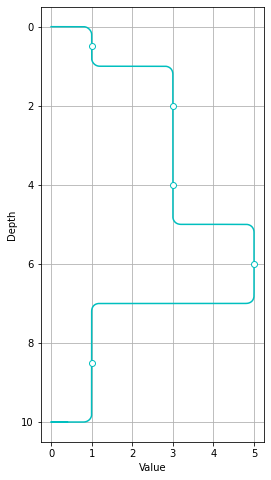

In [4]:
np.random.seed(112)
intervals = np.array([0, 1, 3, 5, 7, 10])
values = np.array([1,3,3,5,1])
fig, ax = plt.subplots(1, figsize=(4, 8))
ax.invert_yaxis()
ax.set(ylabel='Depth', xlabel='Value')
plot_rounded_intervals(intervals, values, ax=ax, rounding=(0.2, 0.2), color="c")

ax.grid()

In [5]:
salinity_values = np.array([0.2, 0.18, 0.1, 0.05, 0.17])
salinity_bounds = np.array([0, 1, 3, 3.5, 5, 6.7 ])

density_values = np.array([0.890, 0.910,0.84,0.85,0.91,0.92,0.91,0.89,0.83,0.91,0.92,0.89,0.92,0.91])
density_bounds = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.3,6.7])

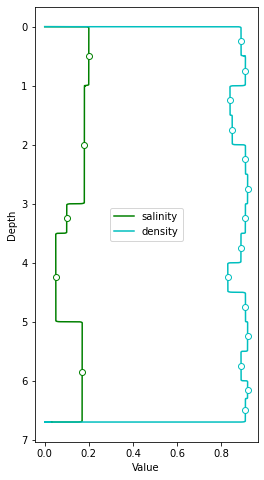

In [6]:
fig, ax = plt.subplots(1, figsize=(4, 8))
ax.invert_yaxis()
ax.set(ylabel='Depth', xlabel='Value')
plot_rounded_intervals(salinity_bounds, salinity_values, ax=ax, rounding=0.02, color="g", label="salinity")
plot_rounded_intervals(density_bounds, density_values, ax=ax, rounding=0.02, color="c", label="density")

plt.legend()

In [7]:
#a real example from JC2-2 P10

In [8]:
density_bounds = np.array([0,5,9.5,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,93,97])

In [9]:
density_values = np.array([0.8813,0.9076,0.7931,0.8644,0.8596,0.8498,0.8793,0.8674,0.8862,0.8809,0.8860,0.8842,0.8970,0.8909,0.9050,0.8927,0.9034,0.9030,0.9013,0.9070])

In [10]:
salinity_bounds = np.array([0,5,10,15,20,30,40,50,60,70,80,90,98])

In [11]:
salinity_values = np.array([1.60,0.60,0.90,1.00,1.20,1.20,1.50,1.80,2.00,2.20,2.20,2.60])

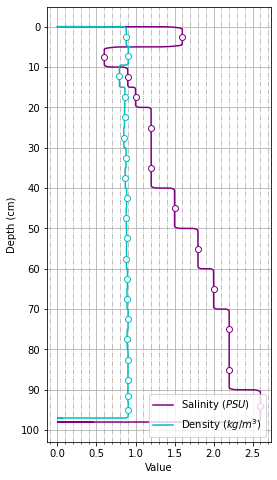

In [26]:
fig, ax = plt.subplots(1, figsize=(4, 8))
ax.invert_yaxis()
ax.set(ylabel='Depth (cm)', xlabel='Value')
plot_rounded_intervals(salinity_bounds, salinity_values, ax=ax, rounding=(0.6, 0.3), color="purple", label="Salinity ($PSU$)")
plot_rounded_intervals(density_bounds, density_values, ax=ax, rounding=(0.5, 0.05), color="c", label="Density ($kg/m^3$)")


plt.legend(loc=0).set_zorder(100)

xspacing = 0.1 # This can be your user specified spacing. 
minorLocator = MultipleLocator(xspacing)
ax.xaxis.set_minor_locator(minorLocator)

yspacing = 10 # This can be your user specified spacing. 
majorLocator = MultipleLocator(yspacing)
ax.yaxis.set_major_locator(majorLocator)

plt.grid(which="minor", linestyle='-.' )

plt.grid(which="major", linestyle='-' )

plt.savefig("../../AeNQ2-p10-main.svg")

In [13]:
describe(density_values)

DescribeResult(nobs=20, minmax=(0.7931, 0.9076), mean=0.882005, variance=0.0007111426052631578, skewness=-1.9354839660980818, kurtosis=4.192574372414234)

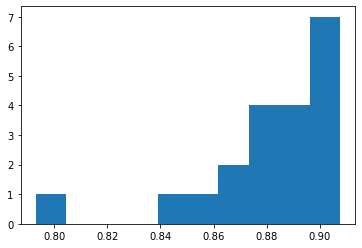

In [14]:
this = plt.hist(density_values)